In [1]:
import numpy as np
import pandas as pd

from keras import backend as K
from keras.models import Model
from keras import initializers
from keras.engine.topology import Layer
from keras.layers import Dense, Input
from keras.layers import Embedding, GRU, LSTM, Bidirectional, TimeDistributed
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint, LambdaCallback, TensorBoard

import os
import pickle

Using TensorFlow backend.


In [2]:
np.random.seed(3)
from tensorflow import set_random_seed
set_random_seed(24)

In [3]:
with open('data_final/reliable_final.pkl', 'rb') as infile:
    reliable = pickle.load(infile)

In [4]:
with open('data_final/unreliable_final.pkl', 'rb') as infile:
    unreliable = pickle.load(infile)

In [5]:
reliable['label'] = 0
unreliable['label'] = 1
data = reliable.append(unreliable)

In [6]:
max_words = 30  # max num words processed for each sentence
max_sentences = 30  # max num sentences processed for each article 
max_vocab = 50000
embedding_dim = 100  # size of pretrained word vectors
attention_dim = 128  # num units in attention layer
GRU_dim = 64  # num units in GRU layer, but it is bidirectional so outputs double this number
batch_size = 128
test_size = 0.2
word_index = {}
embeddings = {}

vector_dir = './embeddings'
vector_file = 'glove.6B.100d.txt'
model_dir = './model_output/glove_100'
tb_logs = './tb_logs/glove_100'

In [7]:
# Split data into train and test sets. Test set will not be used in any way until model is trained.

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

x_train, x_test, y_train, y_test = train_test_split(data['content'], data['label'], test_size=test_size,
                                                    random_state=77, stratify=data['label'])

y_train, y_test = np.asarray(y_train), np.asarray(y_test)

In [8]:
# Build vocab word index (dict) from training articles

from collections import Counter 
words = Counter()
for article in x_train:
    for sentence in article:
        sentence = [word.lower() for word in sentence]
        words.update(sentence)
    
with open('data_final/words.pkl', 'wb') as outfile:
    pickle.dump(words, outfile)

An embedding matrix must be constructed so that the embedding layer can look up and use the vector associated with each word. As an intermediary step, the words are first replaced with their respective indices in the word index. The embedding matrix uses these same indices for the lookup.

Only the most common *n* words will be used from the word index. By pre-populating the data and embedding matrices with zeros, any words outside the *n*-word vocabulary or not found in the set of embedding vectors will be represented by a zero or vector of zeros. The GRU and attention layers support masking, which avoids having to process vectors of all zeros.

Trial runs to ensure that the network is working properly and to determine learning rate bounds (to be used with a cyclic learning rate approach) will be conducted with a small subset of the training data comprising 30,000 articles.

In [9]:
for ix, (word, _) in enumerate(words.most_common(max_vocab)):
    word_index[word] = ix + 1 # The zero index is reserved for masking out-of-vocab words

In [10]:
def create_data_matrix(data, max_sentences=max_sentences, max_words=max_words, max_vocab=max_vocab,
                      word_index=word_index):
    data_matrix = np.zeros((len(data), max_sentences, max_words), dtype='int32')
    for i, article in enumerate(data):
        for j, sentence in enumerate(article):
            if j == max_sentences:
                break
            k = 0
            for word in sentence:
                if k == max_words:
                    break
                ix = word_index.get(word.lower())
                if ix is not None and ix < max_vocab:
                    data_matrix[i, j, k] = ix
                k = k + 1
    return data_matrix  

In [11]:
sample_data = reliable.sample(5000).append(unreliable.sample(5000))

In [12]:
sample_x_train, sample_x_test, sample_y_train, sample_y_test = train_test_split(sample_data['content'],
                                                    sample_data['label'], test_size=test_size,
                                                    random_state=77, stratify=sample_data['label'])

In [13]:
sample_train_matrix = create_data_matrix(sample_x_train)
sample_test_matrix = create_data_matrix(sample_x_test)

sample_y_train = np.asarray(to_categorical(sample_y_train))
sample_y_test = np.asarray(to_categorical(sample_y_test))

sample_data = shuffle(sample_data)  # For finding the learning rate, no validation set needed
sample_targets = np.asarray(to_categorical(sample_data['label']))

In [14]:
with open(os.path.join(vector_dir, vector_file)) as vectors:
    for line in vectors:
        values = line.split()
        word = values[0]
        weights = np.asarray(values[1:], dtype='float32')
        embeddings[word] = weights

In [15]:
embedding_matrix = np.zeros((max_vocab + 1, embedding_dim)) # max_vocab + 1 to account for 0 as masking index
for word, i in word_index.items():
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will remain all zeros.
        embedding_matrix[i] = embedding_vector

In [16]:
# Construct attention layer

from tensorflow import matmul
class HierarchicalAttentionNetwork(Layer):
    ''''''
    def __init__(self, attention_dim):
        self.init_weights = initializers.get('glorot_normal')
        self.init_bias = initializers.get('zeros')
        self.supports_masking = True
        self.attention_dim = attention_dim
        super().__init__()

    def build(self, input_shape):
        assert len(input_shape) == 3
        self.W = K.variable(self.init_weights((input_shape[-1], self.attention_dim)))
        self.b = K.variable(self.init_bias((self.attention_dim,)))
        self.u = K.variable(self.init_weights((self.attention_dim, 1)))
        self.trainable_weights = [self.W, self.b, self.u]
        super().build(input_shape)

    def compute_mask(self, inputs, mask=None):
        return None

    def call(self, x, mask=None):        
        #uit = K.tile(K.expand_dims(self.W, axis=0), (K.shape(x)[0], 1, 1))
        #uit = matmul(x, uit)
        #uit = K.tanh(K.bias_add(uit, self.b))
        #ait = K.dot(uit, self.u)
        #ait = K.squeeze(ait, -1)

        #ait = K.exp(ait)
        
        uit = K.tanh(K.bias_add(K.dot(x, self.W), self.b))
        ait = K.exp(K.squeeze(K.dot(uit, self.u), -1))
        
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting
            ait *= K.cast(mask, K.floatx())
        ait /= K.cast(K.sum(ait, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        
        weighted_input = x * K.expand_dims(ait)
        output = K.sum(weighted_input, axis=1)

        return output

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]

In [82]:
def build_model(attention_dim=attention_dim, GRU_dim=GRU_dim):
    
    embedding_layer = Embedding(len(word_index) + 1, embedding_dim, weights=[embedding_matrix],
                                input_length=max_words, trainable=True, mask_zero=True)

    # layers for processing words in each sentence with attention; output is encoded sentence vector 
    sentence_input = Input(shape=(max_words,), dtype='int32')
    embedded_sequences = embedding_layer(sentence_input)
    lstm_word = Bidirectional(GRU(GRU_dim, return_sequences=True))(embedded_sequences)
    attn_word = HierarchicalAttentionNetwork(attention_dim)(lstm_word)
    sentence_encoder = Model(sentence_input, attn_word)
    
    # layers for processing sentences in each article with attention; output is prediction
    article_input = Input(shape=(max_sentences, max_words), dtype='int32')
    article_encoder = TimeDistributed(sentence_encoder)(article_input)
    lstm_sentence = Bidirectional(GRU(GRU_dim, return_sequences=True))(article_encoder)
    attn_sentence = HierarchicalAttentionNetwork(attention_dim)(lstm_sentence)
    preds = Dense(2, activation='softmax')(attn_sentence)
    
    return Model(article_input, preds)

In [22]:
# create checkpoints to save information from each training epoch

model_checkpoint = ModelCheckpoint(filepath=model_dir+'weights.{epoch:02d}.hdf5')
tb_checkpoint = TensorBoard(log_dir=tb_logs, histogram_freq=1, batch_size=128, write_graph=False, write_grads=True,
                            write_images=True)

if not os.path.exists(model_dir):
        os.makedirs(model_dir, exist_ok=True)
        
if not os.path.exists(tb_logs):
        os.makedirs(tb_logs, exist_ok=True)

The network will be trained using a cyclic learning rate as proposed in the 2017 paper [Cyclical Learning Rates for Training Neural Networks](https://arxiv.org/pdf/1506.01186.pdf). This enables quicker convergence by helping to avoid getting stuck in local minima or saddle points on the loss surface. A [reference implementation](https://github.com/bckenstler/CLR) is available on Github, and a three-post walk-through on [pyimagesearch](https://www.pyimagesearch.com/2019/07/29/cyclical-learning-rates-with-keras-and-deep-learning/) includes code in more detail. The approach has two steps. The first uses a learning rate vs. loss graph to determine the minimum and maximum learning rates. A Keras callback then varies the learning rate back and forth between these two values during training.

In [86]:
K.clear_session()
try:
    del model
except NameError:
    pass
model = build_model()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [87]:
from cyclic.rate_finder import LearningRateFinder
find_lr = LearningRateFinder(model)

find_lr_data = create_data_matrix(sample_data['content'])

In [89]:
find_lr.find(find_lr_data, sample_targets, start_lr=1e-8, end_lr=1., epochs=3, batch_size=batch_size)

Epoch 1/3
10000/10000 [==============================] - 240s 24ms/step - loss: 0.6931 - acc: 0.5181
Epoch 2/3
10000/10000 [==============================] - 236s 24ms/step - loss: 0.6587 - acc: 0.5938
Epoch 3/3
10000/10000 [==============================] - 237s 24ms/step - loss: nan - acc: 0.4893


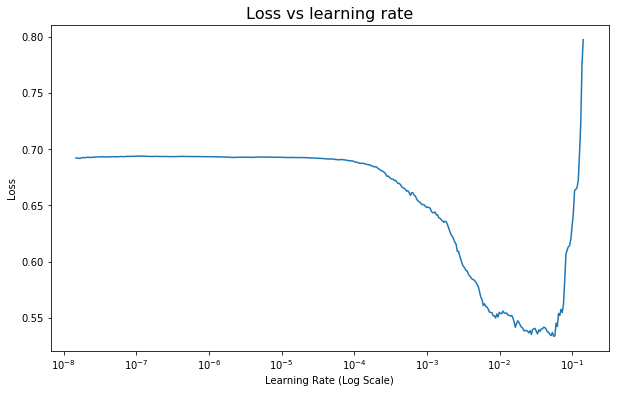

In [99]:
find_lr.plot_loss()

The plot shows that no learning takes place (no drop in loss) while the learning rate is below $10^{-4}$, and
learning becomes erratic and quickly explodes above $10^{-2}$. So the learning rates will cycle between these two values.